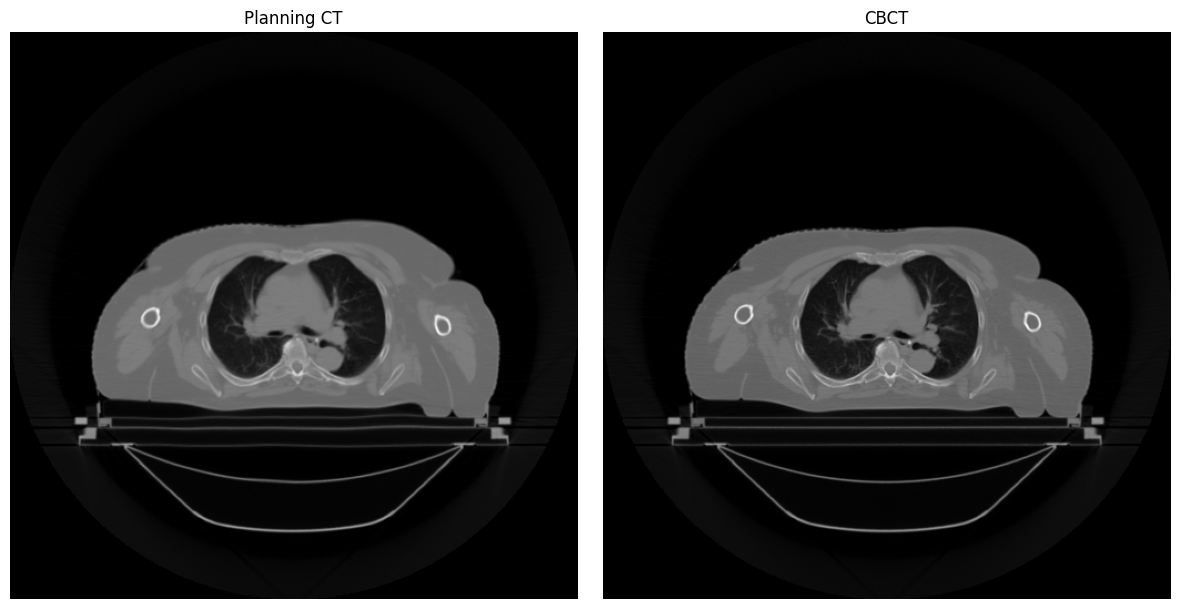

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tranformation_utils import *

# Define file paths and load images.
DATASET_PATH = "dataloader/data/full/SAMPLE_001"
planned_ct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.49998588991250185596277084171475165836.dcm'
cbct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.505160349897793889516650021650971788930.dcm'

# Read the images and drop the extra dimension.
planning_ct = sitk.ReadImage(planned_ct_path)[:, :, 0]
cbct = sitk.ReadImage(cbct_path)[:, :, 0]

plot_images(planning_ct, cbct, "Planning CT", "CBCT")

planning_ct_img = sitk.GetArrayFromImage(planning_ct)
cbct_img = sitk.GetArrayFromImage(cbct)

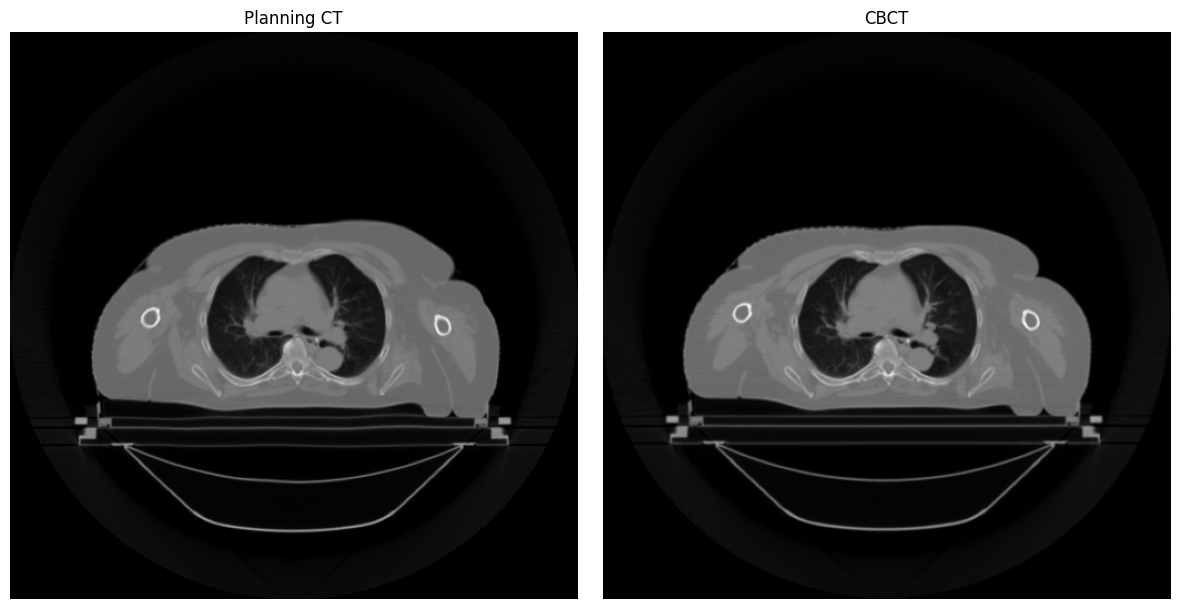

In [ ]:
plot_images(planning_ct, cbct)

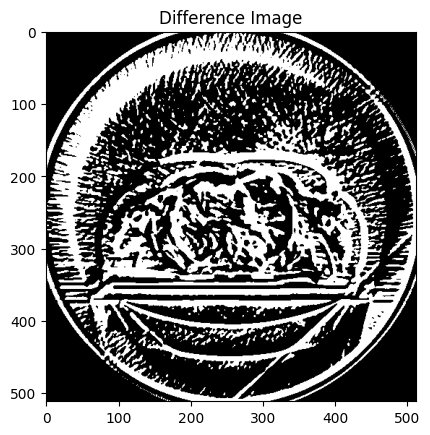

In [3]:
smoothed_planning = sitk.SmoothingRecursiveGaussian(planning_ct, sigma=2.0)
smoothed_cbct = sitk.SmoothingRecursiveGaussian(cbct, sigma=2.0)
    
plot_difference(smoothed_planning, smoothed_cbct)


itk::simple::Euler2DTransform
 Euler2DTransform (0x7f79da80ded0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 55851
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0.000733861 
     0.000733861 1 
   Offset: [-2.01912, -2.09448]
   Center: [-0.6914, 95.3086]
   Translation: [-2.08906, -2.09502]
   Inverse: 
     1 0.000733861 
     -0.000733861 1 
   Singular: 0
   Angle: 0.000733861



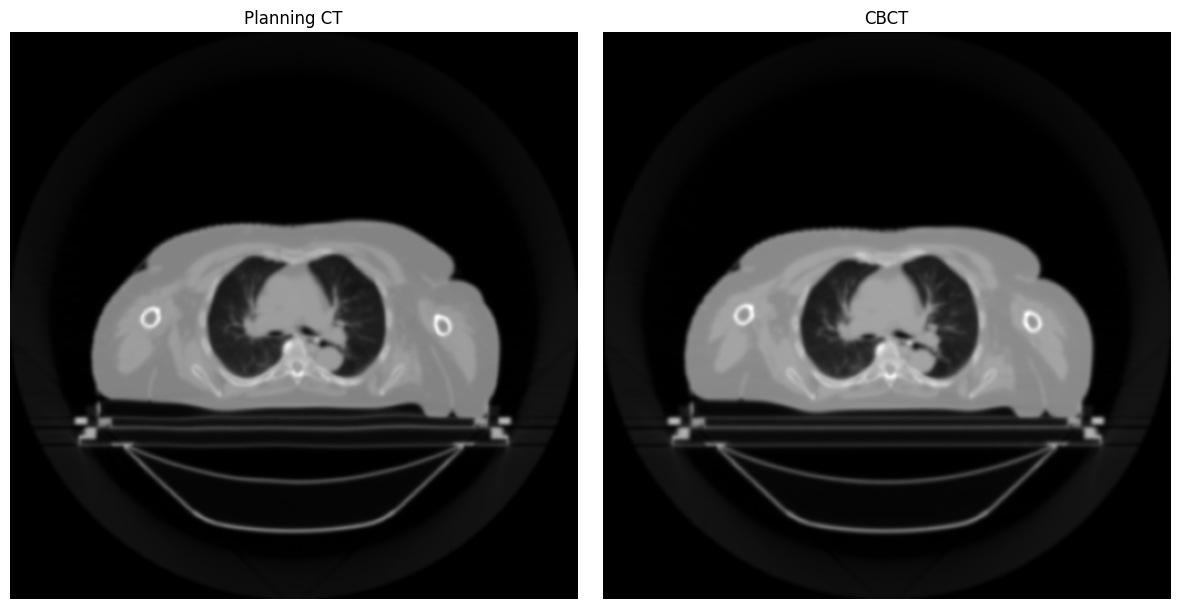

In [ ]:

# Example usage for global alignment:
global_transform = perform_rigid_registration_v2(smoothed_planning, smoothed_cbct)
# Resample to align moving image using the rigid transform.
moving_image_global_aligned = sitk.Resample(smoothed_cbct, smoothed_planning, global_transform,
                                              sitk.sitkLinear, -1000, smoothed_cbct.GetPixelID())

plot_images(smoothed_planning, moving_image_global_aligned)

In [ ]:

fixed_image = smoothed_planning   # e.g., planning CT (fixed)
moving_image = moving_image_global_aligned           # e.g., CBCT (moving)

# Perform deformable registration.
final_bspline_transform = perform_bspline_registration(fixed_image, moving_image, grid_physical_spacing=[50.0, 50.0, 50.0], number_of_iterations=200)

# Apply the BSpline transform to get the deformed (fused) image.
fused_deformed_image = resample_with_transform(moving_image, fixed_image, final_bspline_transform)

Final BSpline registration metric value: -1.5447145804396352
Optimizer's stopping condition: LBFGSBOptimizerv4: Function tolerance reached after 139 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).


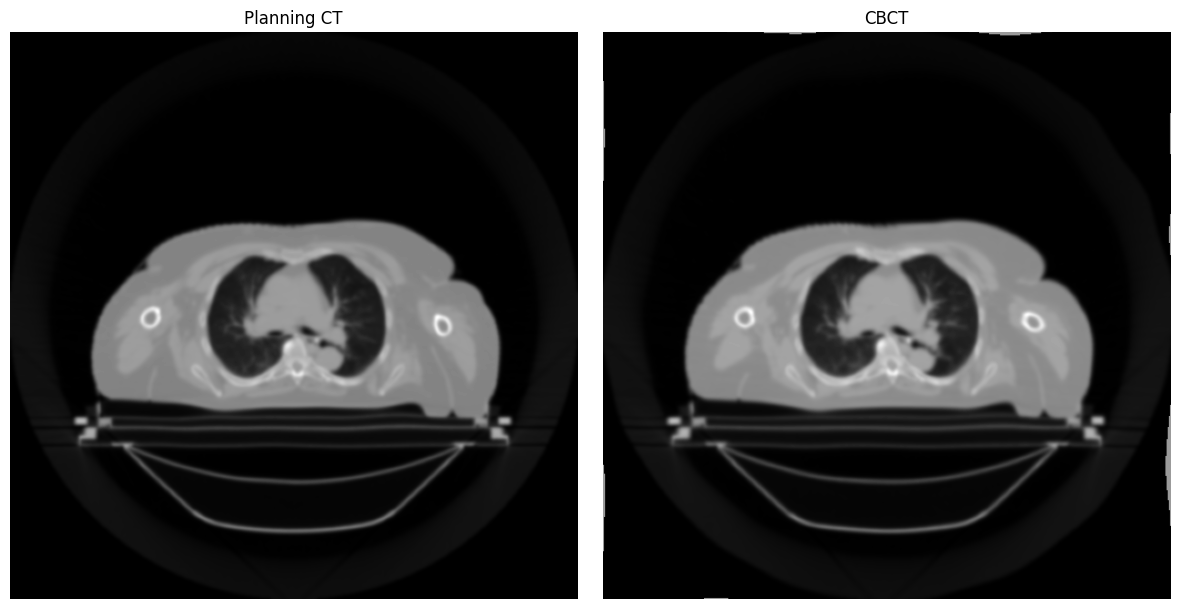

In [6]:
plot_images(fixed_image, fused_deformed_image)

In [ ]:
control_point_spacing_2d = [40.0, 40.0] # Example: 4cm grid spacing in 2D

final_deformable_transform_2d = perform_bspline_deformable_registration_2d(
    fixed_image=smoothed_planning,
    moving_image=moving_image_global_aligned, # Use the globally aligned image
    grid_physical_spacing=control_point_spacing_2d,
    sampling_percentage=0.2, # Maybe increase sampling for 2D?
    num_iterations=50
)

print("\n2D Deformable registration successful.")
# Apply the final composite transform to the *original* moving image
moving_image_deformably_aligned_2d = sitk.Resample(
    moving_image_global_aligned,             # Original 2D moving image
    smoothed_planning,         # Reference space (2D fixed image)
    final_deformable_transform_2d,# The final (possibly composite) 2D transform
    sitk.sitkLinear,
    -1000, # Background value
    moving_image_global_aligned.GetPixelID()
)


LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.



LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.

LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.



Final metric value: -1.434904

2D Deformable registration successful.


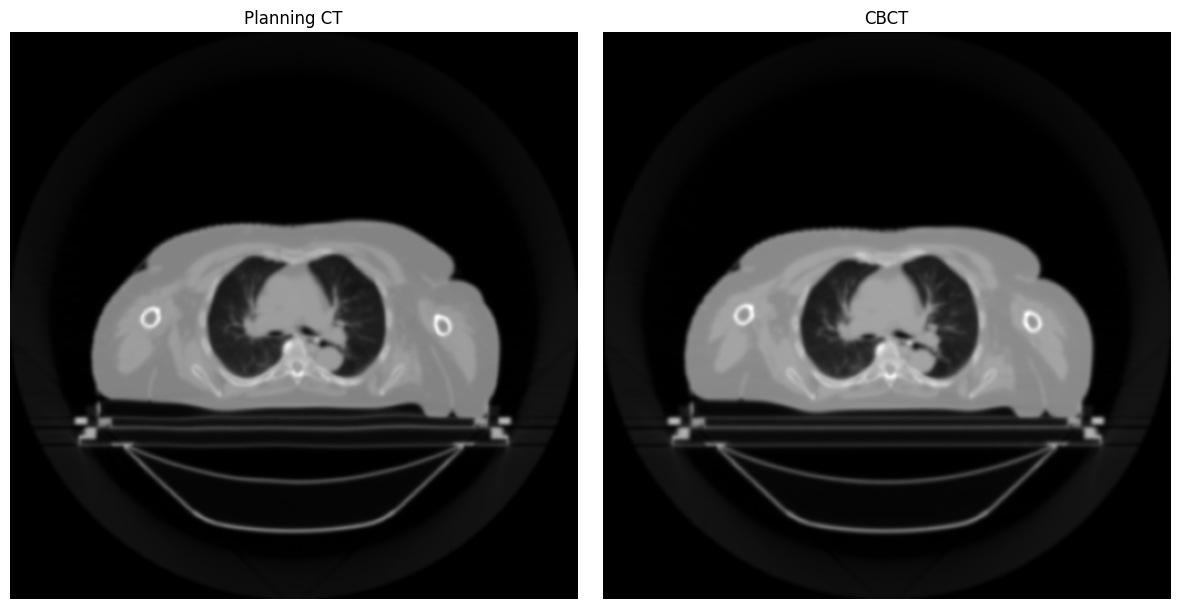

In [8]:
plot_images(smoothed_planning, moving_image_deformably_aligned_2d)

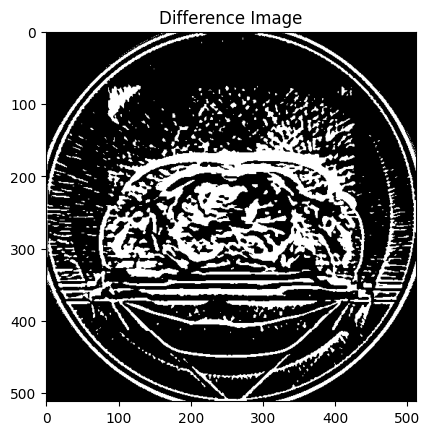

In [11]:
plot_difference(smoothed_planning, moving_image_deformably_aligned_2d)